##  Imports and Common Functions

In [1]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import string
import re

# Dataset - IMDb movie review dataset

def load_imdb_data(datadir):
    # read in training and test corpora
    categories= ['pos', 'neg']
    train_b = load_files(datadir+'/train', shuffle=True, 
                         categories=categories)
    test_b = load_files(datadir+'/test', shuffle=True,
                         categories=categories)    
    train_b.data = [x.decode('utf-8') for x in train_b.data]
    test_b.data =  [x.decode('utf-8') for x in test_b.data]
    y_train = train_b.target
    y_test = test_b.target
    return train_b.data,test_b.data,y_train,y_test


def get_cv(x_train,x_test,max_feats=800000):
    veczr =  CountVectorizer(ngram_range=(1,3), binary=True, 
                             token_pattern=r'\w+',
                             max_features=max_feats)
    dtm_train = veczr.fit_transform(x_train)
    dtm_test = veczr.transform(x_test)
    num_words = len([v for k,v in veczr.vocabulary_.items()]) + 1
#     print('vocab size:%s' % (num_words))  
    return dtm_train, dtm_test


def get_tfidf(x_train,x_test):
    veczr =  TfidfVectorizer(ngram_range=(1,3), binary=True, 
                             token_pattern=r'\w+',
                             max_features=800000)
    dtm_train = veczr.fit_transform(x_train)
    dtm_test = veczr.transform(x_test)
    print("DTM shape (training): (%s, %s)" % (dtm_train.shape))
    print("DTM shape (test): (%s, %s)" % (dtm_train.shape))
    num_words = len([v for k,v in veczr.vocabulary_.items()]) + 1
    print('vocab size:%s' % (num_words))  
    return dtm_train, dtm_test


def get_prob(x_feats,y_i, y):
    p = x_feats[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

# NB Log count ratios
def get_nb_feats(x_feats,y):
    log_rat = np.log(get_prob(x_feats,1,y) / get_prob(x_feats,0,y))
    x_feats_nb = x_feats.multiply(log_rat)
    return x_feats_nb,log_rat

def get_nbsvm_model(x_feats,y):
    # y = y.values       
    x_feats_nb,log_rat = get_nb_feats(x_feats,y)
    model = LogisticRegression(C=10,max_iter=1000)
    model.fit(x_feats_nb, y)
    return model, log_rat

def clean_data(data):
    # Remove <br />
    data = data.replace("<br />","")
    # Change Numbers to XX
    data = re.sub('[0-9]', 'X', data)
    # Remove punctuations
    data = re.sub(r"[,.;@#?!&$/]+"," ",data)
    data = re.sub(r"[-'\"´]+","",data)
    data = data.replace("\'","")
    # lower case
    data = data.lower()
    return data


## Import data and Preprocess

In [2]:
PATH_TO_IMDB = "data/aclImdb"
x_train,x_test,y_train,y_test = load_imdb_data(PATH_TO_IMDB)

x_train_orig = pd.DataFrame({'x_train':x_train})['x_train'].apply(clean_data)
x_test_orig = pd.DataFrame({'x_test':x_test})['x_test'].apply(clean_data)


## Baseline Model Building and Checking

### Subword Tokenization

In [3]:
from tokenizers import ByteLevelBPETokenizer,CharBPETokenizer,SentencePieceBPETokenizer,BertWordPieceTokenizer

tokenizer = SentencePieceBPETokenizer()

f = open("train_text.txt","w")
for each in list(x_train_orig):
    f.write(str(each))
    f.write("\n")

f.close()

tokenizer.train(["./train_text.txt"],vocab_size=2000,min_frequency=2)

encoded_tokens_train = [tokenizer.encode(str(each)).tokens for each in x_train_orig]
encoded_tokens_test = [tokenizer.encode(str(each)).tokens for each in x_test_orig]


x_train = [" ".join(each)  for each in encoded_tokens_train]
x_test = [" ".join(each)  for each in encoded_tokens_test]


In [4]:
x_train[0]

'▁z er o ▁day ▁lead s ▁you ▁to ▁think ▁ ▁even ▁re th ink ▁why ▁two ▁boy s ▁young ▁men ▁would ▁do ▁what ▁they ▁did ▁ ▁comm it ▁m ut ual ▁su ic ide ▁v ia ▁sl augh ter ing ▁their ▁class m ates ▁ ▁it ▁capt ures ▁what ▁must ▁be ▁be y ond ▁a ▁b iz ar re ▁mo d e ▁of ▁being ▁for ▁two ▁hum ans ▁who ▁have ▁dec ided ▁to ▁with d ra w ▁from ▁comm on ▁c iv ility ▁in ▁order ▁to ▁def ine ▁their ▁own ▁m ut ual ▁world ▁v ia ▁cou pl ed ▁dest ru ction ▁it ▁is ▁not ▁a ▁perfect ▁movie ▁but ▁given ▁what ▁money ▁time ▁the ▁filmmak er ▁and ▁actors ▁had ▁ ▁it ▁is ▁a ▁rem ark able ▁produ ct ▁ ▁in ▁ter ms ▁of ▁expl ain ing ▁the ▁mot ives ▁and ▁act ions ▁of ▁the ▁two ▁young ▁su ic ide ▁murder ers ▁it ▁is ▁better ▁than ▁ele ph ant ▁ ▁in ▁ter ms ▁of ▁being ▁a ▁film ▁that ▁gets ▁under ▁our ▁r ational istic ▁sk in ▁it ▁is ▁a ▁far ▁ ▁far ▁better ▁film ▁than ▁almost ▁anything ▁you ▁are ▁like ly ▁to ▁see ▁ ▁fl aw ed ▁but ▁honest ▁with ▁a ▁terrible ▁honest y ▁'

### Count Vectorizers + Logistic

In [5]:
dtm_train, dtm_test = get_cv(x_train,x_test)

clf = LogisticRegression(C=10,n_jobs=1,max_iter=1000)
clf.fit(dtm_train,y_train)

y_pred_prob = clf.predict_proba(dtm_test)
y_pred = np.argmax(y_pred_prob,axis=1)

print("F1 Score on Validation Set", f1_score(y_test, y_pred, average='micro'))

/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 Score on Validation Set 0.89672


### NBSVM with Count Vectorizer

In [6]:
model,log_rat = get_nbsvm_model(dtm_train,y_train)
y_pred_prob = model.predict_proba(dtm_test.multiply(log_rat))
y_pred = np.argmax(y_pred_prob,axis=1)
print("F1 Score on Validation Set", f1_score(y_test, y_pred,average='micro'))

/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 Score on Validation Set 0.91336


### TFIDF + Logistic

In [7]:
dtm_train, dtm_test = get_tfidf(x_train,x_test)

clf = LogisticRegression(C=10,n_jobs=1,max_iter=1000)
clf.fit(dtm_train,y_train)

y_pred_prob = clf.predict_proba(dtm_test)
y_pred = np.argmax(y_pred_prob,axis=1)

print("F1 Score on Validation Set", f1_score(y_test, y_pred, average='micro'))

DTM shape (training): (25000, 800000)
DTM shape (test): (25000, 800000)
vocab size:800001


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 Score on Validation Set 0.9089599999999999


### NBSVM with TFIDF Vectorizer

In [8]:
model,log_rat = get_nbsvm_model(dtm_train,y_train)
y_pred_prob = model.predict_proba(dtm_test.multiply(log_rat))
y_pred = np.argmax(y_pred_prob,axis=1)

print("F1 Score on Validation Set", f1_score(y_test, y_pred,average='micro'))

/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 Score on Validation Set 0.9058


**Finalized baseline model - NBSVM with Count Vectorizer**

### Change Max Features and Check the Optimum

In [45]:
max_feats = list(range(10000,100000,10000)) + list(range(100000,900000,50000))
f1_scores = []
for n_feats in max_feats:
    dtm_train, dtm_test = get_cv(x_train,x_test,n_feats)
    model,log_rat = get_nbsvm_model(dtm_train,y_train)
    y_pred_prob = model.predict_proba(dtm_test.multiply(log_rat))
    y_pred = np.argmax(y_pred_prob,axis=1)
#     print("F1 Score on Validation Set", f1_score(y_test, y_pred,average='micro'))
    f1_scores.append(f1_score(y_test, y_pred,average='micro'))

feat_scores = pd.DataFrame({'feats':max_feats,'f1':f1_scores})

In [44]:
np.save("feat_scores.npy",feat_scores)
np.save("max_feats.npy",max_feats)

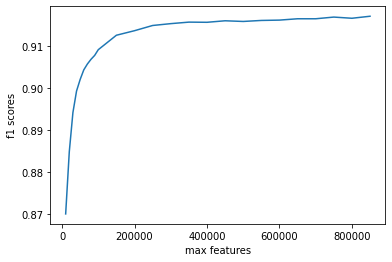

In [46]:
import seaborn as sn    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

ax = sn.lineplot(data=feat_scores, x="feats", y="f1")
ax.set(xlabel='max features', ylabel='f1 scores')
plt.show()
# plt.savefig("feat_scores.jpg")


### Check f1 scores for different sizes of training data


In [16]:
max_feats = 250000
data_split1 = list(range(100,1200,100)) # A more fine grained split till 1100
data_split2 = list(range(5,105,5))  # A coarser split based on percentage after 1100

f1_scores = []
for i,split in enumerate(data_split1+data_split2):
    if i < len(data_split1):
        thresh = int(split)
    else:
        thresh = int(split*len(x_train)/100)
    dtm_train, dtm_test = get_cv(x_train[:thresh],x_test,max_feats)
    model,log_rat = get_nbsvm_model(dtm_train,y_train[:thresh])        
    y_pred_prob = model.predict_proba(dtm_test.multiply(log_rat))
    y_pred = np.argmax(y_pred_prob,axis=1)
#     print("F1 Score on Validation Set", f1_score(y_test, y_pred,average='micro'))
    f1_scores.append(f1_score(y_test, y_pred,average='micro'))

data_size = data_split1 + [int(each/100*len(x_train)) for each in data_split2]
data_split_scores = pd.DataFrame({'data_size':data_size,'f1':f1_scores})

In [11]:
np.save("data_split.npy",data_size)
np.save("f1_scores_data_split.npy",f1_scores)

<Figure size 432x288 with 0 Axes>

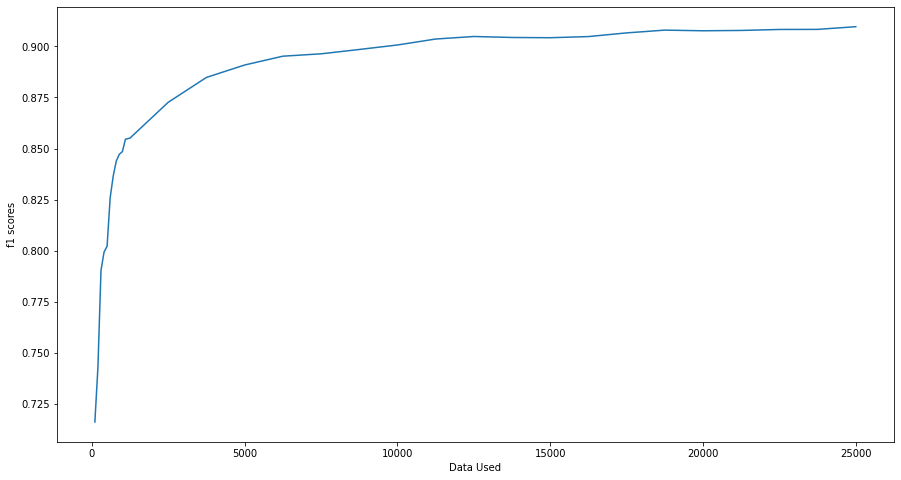

In [13]:
import seaborn as sn    
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# Plot the f1 scores by data sizes
plt.clf()
plt.figure(figsize=(15,8))
ax = sn.lineplot(data=data_split_scores, x="data_size", y="f1")
ax.set(xlabel='Data Used', ylabel='f1 scores')
plt.savefig("data_split_scores.jpg")

In [14]:
data_split_scores

,data_size,f1
0,100,0.71616
1,200,0.74296
2,300,0.79036
3,400,0.79932
4,500,0.80224
5,600,0.82584
6,700,0.83648
7,800,0.84384
8,900,0.84720
9,1000,0.84848


# Evaluating Weak Supervision with Snorkel

In [18]:
# Labels for supervision
ABSTAIN = -1
NEG = 0
POS = 1

pd.options.display.max_colwidth = 1000

sample_size = 500
test_split = x_train_orig[:sample_size]
test_labels = y_train[:sample_size]

pd_test = pd.DataFrame({'text':test_split,'label':test_labels})

weak_supervision_split = x_train_orig[sample_size:]
weak_supervision_labels = y_train[sample_size:]

pd_train = pd.DataFrame({'text':weak_supervision_split,'label':weak_supervision_labels})
pd_train = pd_train.reset_index()

## Labeling Functions

In [19]:
from snorkel.labeling import labeling_function
from snorkel.labeling import PandasLFApplier,LFApplier
from snorkel.labeling import LabelingFunction
from snorkel.preprocess import preprocessor
from snorkel.labeling import LFAnalysis
from snorkel.labeling.model import MajorityLabelVoter,LabelModel
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
from textblob import TextBlob
from sklearn.metrics import accuracy_score

@labeling_function()
def nice_movie(x):
    return POS if "nice movie" in x.text.lower() else ABSTAIN

@labeling_function()
def interesting_script(x):
    return POS if "interesting script" in x.text.lower() else ABSTAIN

@labeling_function()
def great_performance(x):
    return POS if "great performance" in x.text.lower() else ABSTAIN

@labeling_function()
def heart_warming(x):
    return POS if "heart warming" in x.text.lower() else ABSTAIN


def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN


def make_keyword_lf(keywords, label=POS):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

keyword_pos = make_keyword_lf(keywords=['hilarious','commendable','remarkable','finest','fun','excellent',
    'loved','wonderful','enjoyed','brilliant','beautiful','perfectly','perfect','superb','favorite',
    'incredible','amazing','realistic','classic','oscar','leading','appreciate','charming','exhilarating',
    'masterpiece','timeless','love','fantastic','enjoyable','splendid','touching',
    'underrated','accomplished','recommend'],label=POS)

keyword_neg = make_keyword_lf(keywords=['horrible','worst','terrible','sucks','flawed','wasted','waste',
    'awful','stupid','boring','terrible','crap','poor','unfortunately','sadly','disappointed','pretentious',
    'nonsense','inane','mess','gripe','rubbish','confusing','drags','excruciating','peril'],label=NEG)

# Using pretrained TextBlob Model

@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    if x.polarity > 0.5:
        return POS
    if x.polarity < -0.5:
        return NEG
    return ABSTAIN

lfs = [textblob_polarity,keyword_pos,keyword_neg,nice_movie,interesting_script,great_performance,heart_warming]
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=pd_train[['text']])
L_test = applier.apply(df=pd_test[['text']])

100%|██████████| 500/500 [00:01<00:00, 312.24it/s]


Doing an LFAnalysis gives the amount of Coverage and other statistics for each labelling function

In [20]:
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
textblob_polarity,0,"[0, 1]",0.009918,0.008857,0.000408
keyword_hilarious,1,[1],0.718612,0.342857,0.330939
keyword_horrible,2,[0],0.482408,0.332531,0.331592
nice_movie,3,[1],0.000939,0.000816,0.000367
interesting_script,4,[1],0.000204,0.000204,0.000204
great_performance,5,[1],0.007306,0.006653,0.002980
heart_warming,6,[1],0.000980,0.000857,0.000245


#### Sample of those labeled positive by textblob_polarity

In [21]:
pd_train.iloc[L_train[:, 0] == POS].sample(5, random_state=1)

,index,text,label
13182,13682,this movie was incredible i would recommend it to anyone much better than what i had already anticipated it was definitely a heartwrenching spectacular movie it is an amazing story with amazing actors and creators definitely another great movie with denzel washington (shouldnt surprise anyone) derek luke did a wonderful job as well,1
23921,24421,mary tyler moore and valerie harper still can turn the world on with their smiles the combined talent of these two wonderful stars make this combination reunion newstart movie work watch it and look forward to hitting sixty mary defies the youth oriented society with wit and charm a touch of drama adds xxxx realism a tv series follow up would broaden the new characters and give us a chance to occaisionally see lou grant phyllis sue ann murray and georgette,1
12973,13473,this movie is utterly hilarious its cast clicks immediately with frame one and takes us on a wonderful ride through spoofing gangster films the conflict of brother vs brother appears when johnnys brother becomes a dogooder d a however the best character is johnnys crimelord rival the overly accented moroni as johnny says that man should be arrested for butchering the english language check it out on video its worth a look,1
13108,13608,paul grace hartman are my husbands grandparents they were both deceased when we met so watching old movies is a good way to see them and their work i have always enjoyed old movies and was very happy to discover that this was also a very good one,1
6482,6982,i agree with another user here and have to say that this is one of the best kung fu movies ever i watched this as a kid and absolutely loved it the scaffolding scenes are brilliant and you can really empathise with this guy because he is treated as an outcast nice humour and fantastic kung fu this movie rocks if you like kung fu you would love this,1


#### Sample of those labeled negative by textblob_polarity

In [22]:
pd_train.iloc[L_train[:, 0] == NEG].sample(5, random_state=1)

,index,text,label
19876,20376,comment this movie is impossible is terrible very improbable bad interpretation e direction not look,0
13928,14428,we brought this film as a joke for a friend and could of been our worst joke to play the film is barely watchable and the acting is dire the worst child actor ever used and hasslehoff giving a substandard performance the plot is disgraceful and at points we was so bored we was wondering what the hell was going on it tries to be gruesome in places but is just laughable just terrible,0
17821,18321,i have seen over xxxx movies and this one stands out as one of the worst movies that i have ever seen it is a shame that they had to associate this garbage to the angels xxxx song my boyfriends back if you have to make a choice between watching this movie and painful dental work i would suggest the dental work,0
18623,19123,this movie is not for the faint or weak of heart it couldnt decide if it was going to be porn or legit it was neither one it was just bad there was nothing in this movie to make me want to see anything else made by these people again,0
11906,12406,i was looking on imdbs bottom xxx because i thought id never seen anything as bad as plan x from outerspace or roller ball remake i was wrong ben and arthur has beaten both this out of the many countless amount of movies ive seen is the number one worst film on the i ever saw bad directing bad characters horrible acting horrible story theres a reason nobody but sam ever says anything positive about this film sam was a horrible annoying actor but his directing was so bad he may just overthrow ed wood the director should be ashamed of his work unfortunately i have to give it at least x star but it deserves to be continued stars,0


#### Predicting the label using a model based on Labelling functions

In [23]:
majority_model = MajorityLabelVoter()
preds_train_maj = majority_model.predict(L=L_train)
preds_test_maj = majority_model.predict(L=L_test)


label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)
preds_train_label_model = label_model.predict(L=L_train)
preds_test_label_model = label_model.predict(L=L_test)



/home/kicompute/venv/lib/python3.6/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


#### Prediction on test and checking accuracy

In [24]:
majority_acc = majority_model.score(L=L_test, Y=pd_test['label'], tie_break_policy="random")[
    "accuracy"
]
# print(f"{'Majority Vote Accuracy:':<25} {majority_acc * 100:.1f}%")

train_acc_maj = accuracy_score(pd_train.loc[np.where(preds_train_maj!=-1)[0],'label'], 
    preds_train_maj[np.where(preds_train_maj!=-1)[0]])

test_acc_maj = accuracy_score(pd_test.loc[np.where(preds_test_maj!=-1)[0],'label'], 
    preds_test_maj[np.where(preds_test_maj!=-1)[0]])

print("Majority model accuracy on unlabelled set :",train_acc_maj)
print("Majority model accuracy on gold set :",test_acc_maj)

label_model_acc = label_model.score(L=L_test, Y=pd_test['label'], tie_break_policy="random")[
    "accuracy"
]
# print(f"{'Label Model Accuracy:':<25} {label_model_acc * 100:.1f}%")

train_acc_lab = accuracy_score(pd_train.loc[np.where(preds_train_label_model!=-1)[0],'label'], preds_train_label_model[np.where(preds_train_label_model!=-1)[0]])

test_acc_lab = accuracy_score(pd_test.loc[np.where(preds_test_label_model!=-1)[0]]['label'], preds_test_label_model[np.where(preds_test_label_model!=-1)[0]])

print("Label model accuracy on unlabelled set :",train_acc_lab)
print("Label model accuracy on gold set :",test_acc_lab)

Majority model accuracy on unlabelled set : 0.807637482181709
Majority model accuracy on gold set : 0.87248322147651
Label model accuracy on unlabelled set : 0.6367593372648133
Label model accuracy on gold set : 0.7321428571428571


We will consider the majority label model for our purposes owing to higher accuracy

#### Filter out the unlabelled

In [28]:
def custom_filter(df_train,preds_train_maj):
    df_train_filtered = df_train.loc[np.where(preds_train_maj!=-1)[0]]
    preds_train_filtered = preds_train_maj[np.where(preds_train_maj!=-1)[0]]
    return df_train_filtered,preds_train_filtered


# probs_train = majority_model.predict_proba(L=L_train)
# df_train_filtered, probs_train_filtered = filter_unlabeled_dataframe(
#     X=pd_train, y=probs_train, L=L_train
# )
# preds_train_filtered = probs_to_preds(probs=probs_train_filtered)
# accuracy_score(df_train_filtered['label'], preds_train_filtered)

df_train_filtered,preds_train_filtered = custom_filter(pd_train,preds_train_maj)
print(accuracy_score(df_train_filtered['label'], preds_train_filtered))


0.807637482181709


#### Train Baseline Classifier ( NBSVM + CV) with gold set + weakly supervised set


In [29]:
gold_set = pd_test.copy()

weak_set = df_train_filtered.copy()
weak_set = weak_set.drop(columns=['label'])
weak_set['label'] = preds_train_filtered

final_set = pd.concat([gold_set,weak_set])

len(final_set)

encoded_tokens = [tokenizer.encode(str(each)).tokens for each in final_set['text']]
encoded_tokens = [" ".join(each)  for each in encoded_tokens]

dtm_train, dtm_test = get_cv(encoded_tokens,x_test,max_feats=max_feats)
model,log_rat = get_nbsvm_model(dtm_train,np.array(final_set['label']))
y_pred_prob = model.predict_proba(dtm_test.multiply(log_rat))
# y_pred_prob = model.predict_proba(test_term_doc)
y_pred = np.argmax(y_pred_prob,axis=1)

print("F1 Score on Validation Set", f1_score(y_test, y_pred,average='micro'))



/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 Score on Validation Set 0.7502


### Checking f1 score for different sizes of gold set coupled with weak supervision for remaining


In [30]:
def get_weak_set(pd_train,applier):
    L_train = applier.apply(df=pd_train[['text']])
    majority_model = MajorityLabelVoter()
    preds_train_maj = majority_model.predict(L=L_train)    
    df_train_filtered, preds_train_filtered = custom_filter(pd_train,preds_train_maj)
    # preds_train_filtered = probs_to_preds(probs=probs_train_filtered)
    labeled_pd = pd.DataFrame({'text':df_train_filtered['text'],'label':preds_train_filtered})
    return labeled_pd

max_feats = 250000
data_split1 = list(range(100,1200,100))  # Fine grained Split
data_split2 = list(range(5,105,5))       # Coarser Split

f1_scores_ws = []
for i,split in enumerate(data_split1+data_split2):
    if i < len(data_split1):
        thresh = int(split)
    else:
        thresh = int(split*len(x_train)/100)
    gold_set = pd.DataFrame({'text':x_train_orig[:thresh],'label':y_train[:thresh]})
    print("Size of gold set ",len(gold_set))
    weak_set = pd.DataFrame({'text':x_train_orig[thresh:]})
    if len(weak_set) > 0:
        weak_set = weak_set.reset_index()
        weak_supervision_set = get_weak_set(weak_set,applier)
        print("Size of weak supervision set :",len(weak_supervision_set))
        final_set = pd.concat([gold_set,weak_supervision_set])
    else:
        final_set = gold_set
    encoded_tokens_train = [tokenizer.encode(str(each)).tokens for each in final_set['text']]
    encoded_tokens_train = [" ".join(each)  for each in encoded_tokens_train]    
    dtm_train, dtm_test = get_cv(encoded_tokens_train,x_test,max_feats)
    model,log_rat = get_nbsvm_model(dtm_train,np.array(final_set['label']))
    y_pred_prob = model.predict_proba(dtm_test.multiply(log_rat))
    # y_pred_prob = model.predict_proba(test_term_doc)
    y_pred = np.argmax(y_pred_prob,axis=1)
    print("F1 Score on Validation Set", f1_score(y_test, y_pred,average='micro'))
    f1_scores_ws.append(f1_score(y_test, y_pred,average='micro'))




  0%|          | 124/24900 [00:00<00:20, 1233.37it/s]

Size of gold set  100


100%|██████████| 24900/24900 [00:15<00:00, 1576.39it/s]


Size of weak supervision set : 13571


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 149/24800 [00:00<00:16, 1471.89it/s]

F1 Score on Validation Set 0.7408800000000001
Size of gold set  200


100%|██████████| 24800/24800 [00:17<00:00, 1441.19it/s]


Size of weak supervision set : 13515


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 152/24700 [00:00<00:16, 1516.81it/s]

F1 Score on Validation Set 0.7446799999999999
Size of gold set  300


100%|██████████| 24700/24700 [00:18<00:00, 1344.72it/s]


Size of weak supervision set : 13452


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 134/24600 [00:00<00:18, 1338.97it/s]

F1 Score on Validation Set 0.74584
Size of gold set  400


100%|██████████| 24600/24600 [00:18<00:00, 1365.34it/s]


Size of weak supervision set : 13388


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 129/24500 [00:00<00:18, 1289.82it/s]

F1 Score on Validation Set 0.74764
Size of gold set  500


100%|██████████| 24500/24500 [00:15<00:00, 1547.54it/s]


Size of weak supervision set : 13329


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 164/24400 [00:00<00:14, 1626.87it/s]

F1 Score on Validation Set 0.7502
Size of gold set  600


100%|██████████| 24400/24400 [00:16<00:00, 1499.54it/s]


Size of weak supervision set : 13274


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 133/24300 [00:00<00:18, 1324.21it/s]

F1 Score on Validation Set 0.7542800000000001
Size of gold set  700


100%|██████████| 24300/24300 [00:15<00:00, 1532.52it/s]


Size of weak supervision set : 13222


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 161/24200 [00:00<00:14, 1605.05it/s]

F1 Score on Validation Set 0.75752
Size of gold set  800


100%|██████████| 24200/24200 [00:15<00:00, 1533.65it/s]


Size of weak supervision set : 13170


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 153/24100 [00:00<00:15, 1522.12it/s]

F1 Score on Validation Set 0.75836
Size of gold set  900


100%|██████████| 24100/24100 [00:15<00:00, 1539.03it/s]


Size of weak supervision set : 13119


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 133/24000 [00:00<00:17, 1326.07it/s]

F1 Score on Validation Set 0.7598799999999999
Size of gold set  1000


100%|██████████| 24000/24000 [00:15<00:00, 1525.58it/s]


Size of weak supervision set : 13065


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 153/23900 [00:00<00:15, 1526.05it/s]

F1 Score on Validation Set 0.76256
Size of gold set  1100


100%|██████████| 23900/23900 [00:14<00:00, 1642.68it/s]


Size of weak supervision set : 13013


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 151/23750 [00:00<00:15, 1507.41it/s]

F1 Score on Validation Set 0.76348
Size of gold set  1250


100%|██████████| 23750/23750 [00:14<00:00, 1601.97it/s]


Size of weak supervision set : 12932


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 140/22500 [00:00<00:15, 1397.86it/s]

F1 Score on Validation Set 0.76636
Size of gold set  2500


100%|██████████| 22500/22500 [00:13<00:00, 1641.71it/s]


Size of weak supervision set : 12228


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 165/21250 [00:00<00:12, 1645.62it/s]

F1 Score on Validation Set 0.7822
Size of gold set  3750


100%|██████████| 21250/21250 [00:13<00:00, 1574.53it/s]


Size of weak supervision set : 11564


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 174/20000 [00:00<00:11, 1729.49it/s]

F1 Score on Validation Set 0.79588
Size of gold set  5000


100%|██████████| 20000/20000 [00:12<00:00, 1638.94it/s]


Size of weak supervision set : 10884


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 118/18750 [00:00<00:15, 1169.56it/s]

F1 Score on Validation Set 0.80988
Size of gold set  6250


100%|██████████| 18750/18750 [00:11<00:00, 1653.99it/s]


Size of weak supervision set : 10212


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 162/17500 [00:00<00:10, 1618.25it/s]

F1 Score on Validation Set 0.8212
Size of gold set  7500


100%|██████████| 17500/17500 [00:11<00:00, 1585.16it/s]


Size of weak supervision set : 9537


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 118/16250 [00:00<00:13, 1178.76it/s]

F1 Score on Validation Set 0.83168
Size of gold set  8750


100%|██████████| 16250/16250 [00:10<00:00, 1482.21it/s]


Size of weak supervision set : 8850


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 150/15000 [00:00<00:09, 1497.43it/s]

F1 Score on Validation Set 0.84208
Size of gold set  10000


100%|██████████| 15000/15000 [00:10<00:00, 1414.11it/s]


Size of weak supervision set : 8174


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 153/13750 [00:00<00:08, 1527.29it/s]

F1 Score on Validation Set 0.8496
Size of gold set  11250


100%|██████████| 13750/13750 [00:09<00:00, 1526.89it/s]


Size of weak supervision set : 7451


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|          | 153/12500 [00:00<00:08, 1524.09it/s]

F1 Score on Validation Set 0.85816
Size of gold set  12500


100%|██████████| 12500/12500 [00:08<00:00, 1546.64it/s]


Size of weak supervision set : 6779


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|▏         | 143/11250 [00:00<00:07, 1424.27it/s]

F1 Score on Validation Set 0.86624
Size of gold set  13750


100%|██████████| 11250/11250 [00:07<00:00, 1505.70it/s]


Size of weak supervision set : 6090


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  1%|▏         | 147/10000 [00:00<00:06, 1467.52it/s]

F1 Score on Validation Set 0.87368
Size of gold set  15000


100%|██████████| 10000/10000 [00:06<00:00, 1657.53it/s]


Size of weak supervision set : 5435


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  2%|▏         | 156/8750 [00:00<00:05, 1551.71it/s]

F1 Score on Validation Set 0.87944
Size of gold set  16250


100%|██████████| 8750/8750 [00:05<00:00, 1634.56it/s]


Size of weak supervision set : 4785


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  2%|▏         | 158/7500 [00:00<00:04, 1574.85it/s]

F1 Score on Validation Set 0.8848
Size of gold set  17500


100%|██████████| 7500/7500 [00:04<00:00, 1653.20it/s]


Size of weak supervision set : 4078


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  3%|▎         | 162/6250 [00:00<00:03, 1619.43it/s]

F1 Score on Validation Set 0.88796
Size of gold set  18750


100%|██████████| 6250/6250 [00:03<00:00, 1621.89it/s]


Size of weak supervision set : 3395


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  3%|▎         | 160/5000 [00:00<00:03, 1590.44it/s]

F1 Score on Validation Set 0.893
Size of gold set  20000


100%|██████████| 5000/5000 [00:03<00:00, 1651.55it/s]


Size of weak supervision set : 2695


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  4%|▍         | 156/3750 [00:00<00:02, 1553.11it/s]

F1 Score on Validation Set 0.8988000000000002
Size of gold set  21250


100%|██████████| 3750/3750 [00:02<00:00, 1644.94it/s]


Size of weak supervision set : 2024


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
  6%|▌         | 153/2500 [00:00<00:01, 1521.10it/s]

F1 Score on Validation Set 0.90132
Size of gold set  22500


100%|██████████| 2500/2500 [00:01<00:00, 1549.70it/s]


Size of weak supervision set : 1351


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
 13%|█▎        | 165/1250 [00:00<00:00, 1649.54it/s]

F1 Score on Validation Set 0.90436
Size of gold set  23750


100%|██████████| 1250/1250 [00:00<00:00, 1635.22it/s]


Size of weak supervision set : 676


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 Score on Validation Set 0.9062799999999999
Size of gold set  25000


/home/kicompute/venv/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 Score on Validation Set 0.90964


In [31]:
np.save("f1_scores_ws.npy",f1_scores_ws)

In [32]:
data_split = data_split1 + [int(each/100*len(x_train)) for each in data_split2]
weak_supervision_scores = pd.DataFrame({'data_size':data_split,'f1':f1_scores,'f1_ws':f1_scores_ws})
weak_supervision_scores

,data_size,f1,f1_ws
0,100,0.71616,0.74088
1,200,0.74296,0.74468
2,300,0.79036,0.74584
3,400,0.79932,0.74764
4,500,0.80224,0.75020
5,600,0.82584,0.75428
6,700,0.83648,0.75752
7,800,0.84384,0.75836
8,900,0.84720,0.75988
9,1000,0.84848,0.76256


<Figure size 432x288 with 0 Axes>

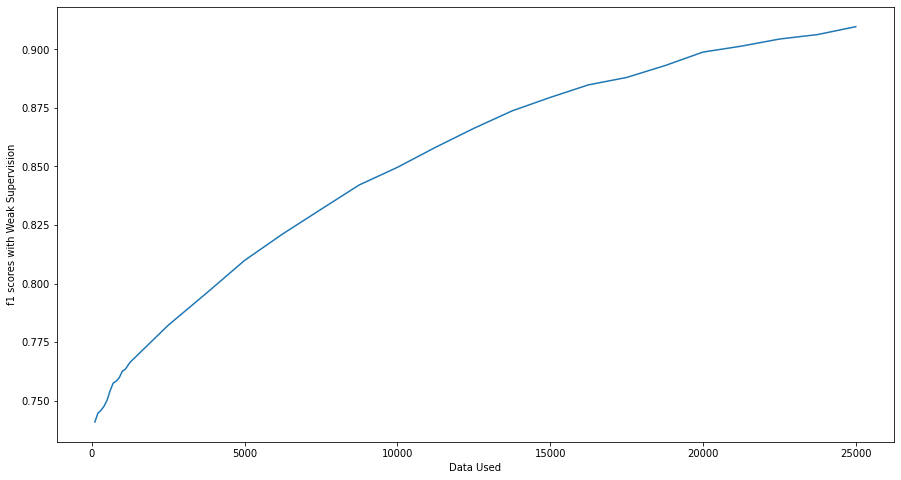

In [33]:
# Plot the f1 scores by data sizes
plt.clf()
plt.figure(figsize=(15,8))
ax = sn.lineplot(data=weak_supervision_scores, x="data_size", y="f1_ws")
ax.set(xlabel='Data Used', ylabel='f1 scores with Weak Supervision')
plt.show()
# plt.savefig("data_split_ws_scores.jpg")